In [8]:
import pandas as pd
import io
import requests
from datetime import datetime
from collections import defaultdict

import matplotlib.pyplot as plt

def loadfiles():
    prefix = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
    filenames={'confirmed':'time_series_19-covid-Confirmed.csv',
       'deaths':'time_series_19-covid-Deaths.csv',
       'recovered':'time_series_19-covid-Recovered.csv'}
    result={}
    for file in filenames.keys():
        url = prefix+filenames[file]
        s=requests.get(url).content
        result[file]=pd.read_csv(io.StringIO(s.decode('utf-8')))
    return result
files = loadfiles()
        

In [15]:
def transform_vals(files,name):
    values = defaultdict(list)
    df = files[name]
    dates = [datetime.strptime(d,'%m/%d/%y') for d in df.columns[4:]]
    for row in df.iterrows():
        vals = row[1][4:]
        province_state = row[1][0]
        country = row[1][1]
        lat = row[1][2]
        lon = row[1][3]
        for i in range(len(vals)):
            values['province_state'].append(province_state)
            values['country'].append(country)
            values['lat'].append(lat)
            values['lon'].append(lon)
            values['date'].append(dates[i])
            values[name].append(vals[i])
    return values

def loadDF(files):
    values = transform_vals(files,'confirmed')
    values['deaths']=transform_vals(files,'deaths')['deaths']
    values['recovered']=transform_vals(files,'recovered')['recovered']
    return pd.DataFrame.from_dict(values)
df = loadDF(files)
df.to_csv('data.csv')
del df['lat']
del df['lon']

displaydate = max(df['date'])
#displaydate = '2020/03/13'
print(displaydate)
df[df['date']==displaydate].groupby(['country']).sum().sort_values(by=['confirmed'], ascending=False)

2020-03-15 00:00:00


,confirmed,deaths,recovered
country,,,
China,81003,3203,67017
Italy,24747,1809,2335
Iran,13938,724,4590
"Korea, South",8162,75,510
Spain,7798,289,517
Germany,5795,11,46
France,4513,91,12
US,3499,63,12
Switzerland,2200,14,4


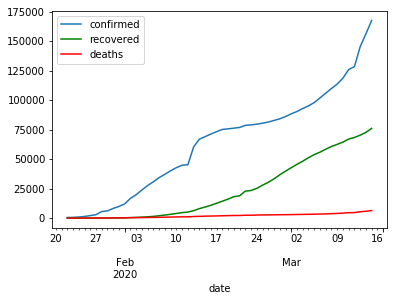

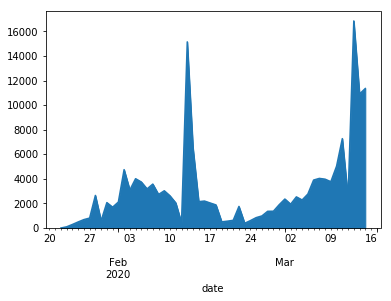

In [10]:
def plotvals(df):
    df=df.groupby(['date']).sum()
    ax = plt.gca()
    df.plot(kind='line',y='confirmed',ax=ax)
    df.plot(kind='line',y='recovered',color='green', ax=ax)
    df.plot(kind='line',y='deaths', color='red', ax=ax)
    plt.show()
def plot_daily_change(df):
    diff = df.groupby(['date']).sum()['confirmed'].diff()
    
    diff.plot(kind='area',y='confirmed',)
    plt.show()
    
plotvals(df)
plot_daily_change(df)

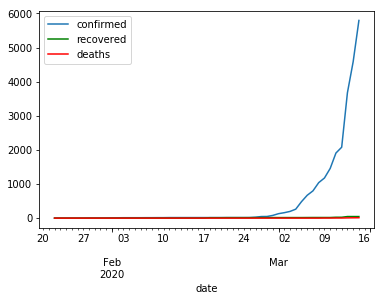

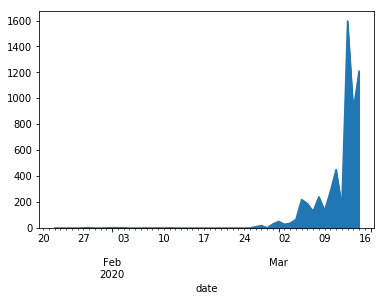

In [11]:
plotvals(df[df['country']=='Germany'])
plot_daily_change(df[df['country']=='Germany'])

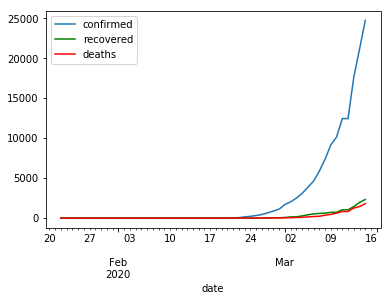

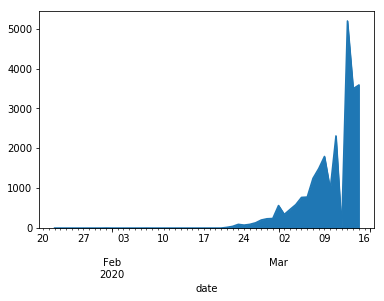

In [12]:
plotvals(df[df['country']=='Italy'])
plot_daily_change(df[df['country']=='Italy'])

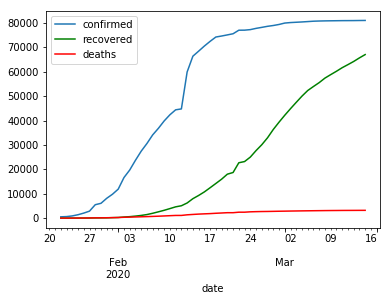

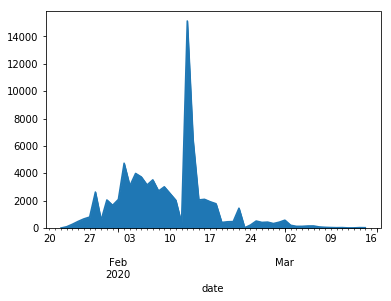

In [13]:
plotvals(df[df['country']=='China'])
plot_daily_change(df[df['country']=='China'])

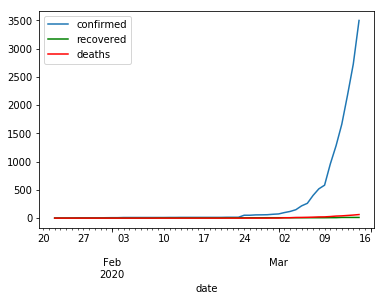

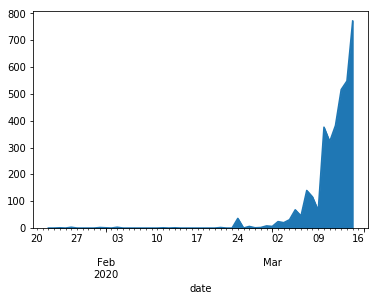

In [14]:
plotvals(df[df['country']=='US'])
plot_daily_change(df[df['country']=='US'])